In [1]:
import dataset
import tensorflow as tf
import numpy as np
from tensorflow.keras import regularizers

In [2]:
texts, sentiments = dataset.load()
test_texts, test_sentiments = dataset.load_test()

In [3]:
texts[0], sentiments[0]

(' I`d have responded, if I were going', 'neutral')

In [4]:
test_texts[0], test_sentiments[0]

('Last session of the day  http://twitpic.com/67ezh', 'neutral')

In [5]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(8000)
tokenizer.fit_on_texts(texts)

vocab_size = tokenizer.num_words

In [6]:
ds_train = dataset.getDataset(tokenizer, batch_size=256)
ds_test = dataset.getDataset(tokenizer, batch_size=256, test=True)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, embeddings_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=None, recurrent_regularizer=None)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=None, recurrent_regularizer=None)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=None),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [9]:
history = model.fit(ds_train, epochs=50, validation_data=ds_test)

Train for 107 steps, validate for 13 steps
Epoch 1/50
107/107 [==============================] - 11s 98ms/step - loss: 10.6732 - accuracy: 0.4026 - val_loss: 9.0247 - val_accuracy: 0.4053
Epoch 2/50
107/107 [==============================] - 2s 20ms/step - loss: 7.8235 - accuracy: 0.4046 - val_loss: 6.7620 - val_accuracy: 0.4029
Epoch 3/50
107/107 [==============================] - 2s 20ms/step - loss: 5.9705 - accuracy: 0.4045 - val_loss: 5.2626 - val_accuracy: 0.4047
Epoch 4/50
107/107 [==============================] - 2s 20ms/step - loss: 4.7239 - accuracy: 0.4046 - val_loss: 4.2357 - val_accuracy: 0.4038
Epoch 5/50
107/107 [==============================] - 2s 20ms/step - loss: 3.8546 - accuracy: 0.4047 - val_loss: 3.5033 - val_accuracy: 0.4099
Epoch 6/50
107/107 [==============================] - 2s 20ms/step - loss: 3.2245 - accuracy: 0.4049 - val_loss: 2.9643 - val_accuracy: 0.4038
Epoch 7/50
107/107 [==============================] - 2s 20ms/step - loss: 2.7520 - accuracy: 0.4

In [27]:
predictions = model.predict(ds_test)

In [28]:
confusion = np.zeros((3,3))
for batch in ds_test:
    predictions = model.predict(batch[0])
    for true, pred in zip(batch[1], predictions):
        true_label = np.argmax(true)
        pred_label = np.argmax(pred)
        confusion[true_label, pred_label] +=1

print(confusion)

[[899. 292. 162.]
 [209. 797.  29.]
 [347.  51. 542.]]


In [29]:
import matplotlib.pyplot as plt

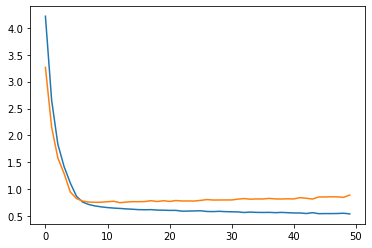

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

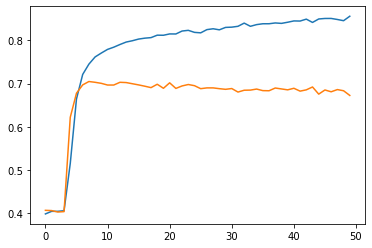

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [21]:
model.layers[0].weights


[<tf.Variable 'embedding/embeddings:0' shape=(8000, 64) dtype=float32, numpy=
 array([[-0.01400528,  0.02834191, -0.04320465, ..., -0.02031782,
         -0.05642011, -0.02816749],
        [ 0.05750417,  0.02673406,  0.01213269, ..., -0.00177052,
          0.01421727, -0.00307568],
        [-0.03848934,  0.03440341, -0.01720465, ..., -0.00240084,
          0.01153829, -0.02055586],
        ...,
        [-0.00443804,  0.02475319,  0.04597781, ...,  0.01197254,
         -0.06498908, -0.02511401],
        [-0.02772023,  0.04161416, -0.0154543 , ...,  0.0314756 ,
          0.00385734, -0.04727641],
        [ 0.06614525,  0.05769709,  0.03472272, ...,  0.05833463,
         -0.06558944,  0.01022734]], dtype=float32)>]

In [33]:
sum([1 if sent == 'neutral' else 0 for sent in test_sentiments])

1430

In [34]:
len(test_sentiments)

3534

In [35]:
1430/3534

0.4046406338426712